In [619]:
import pyodbc 
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from pandas.tseries.offsets import BDay

In [2]:
'''Connect to post result SQL server'''
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=dsa-ln-TQA1V;DATABASE=qai;Trusted_Connection=yes')   
cursor = cnxn.cursor() 

In [3]:
datetime.datetime.now()

datetime.datetime(2019, 1, 8, 7, 46, 43, 461237)

## Data acquisition

In [722]:
'''
Stock information
'''
US_info_sql="select * from IBESInfo3"
US_info=pd.read_sql(US_info_sql,cnxn)

In [723]:
'''
Broker level estimates
'''

US_broker_sql="select * from IBDEstL1 where PerType=1 and Period<4 and year(EstDate)>2014 and year(EstDate)<2018"
US_broker_df=pd.read_sql(US_broker_sql,cnxn)

In [724]:
'''
Sort the data and compute the percentage change vs previous estimate
Take a while to run
'''
def broker_df_sort(broker_df):
    sorted_broker_df=broker_df.sort_values(by=["Code","Broker","PerDate","EstDate"])
    sorted_broker_df["last"]=list(zip(sorted_broker_df["Code"].shift(1),sorted_broker_df["Broker"].shift(1),\
                                    sorted_broker_df["PerDate"].shift(1)))
    sorted_broker_df["last_value"]=sorted_broker_df["Value_"].shift(1)
    sorted_broker_df["pct_chg"]=sorted_broker_df.apply(lambda x:(x["Value_"]-x["last_value"])/abs(x["last_value"]) if \
                         x["Code"]==x["last"][0] and type(x["last_value"])==float and x["Broker"]==x["last"][1] and\
                        x["PerDate"]==x["last"][2] and x["last_value"]!=0 else np.nan,axis=1)
    return sorted_broker_df

In [725]:
sorted_US_broker_df=broker_df_sort(US_broker_df)

In [726]:
'''
Daily consensus data
'''

US_consensus_sql=\
"select * from IBESUSDLYEST where PerType=1 and Period<4 and Measure=8 and year(EstDate)>2014 and year(EstDate)<2018"
US_consensus_df=pd.read_sql(US_consensus_sql,cnxn)

In [840]:
'''
Actual reporting data
'''

US_actual_sql="select * from IBDActL1 where PerType='Q'and year(RptDate)>2015 and year(RptDate)<2018"
US_actual_df=pd.read_sql(US_actual_sql,cnxn)

In [841]:
'''
Only focus on the US universe
'''
adj_US_actual_df=US_actual_df[US_actual_df.apply(lambda x:US_info[US_info.Code==x.Code]["Country"].iloc[0],axis=1)=='NA']

## Key utility functions

In [876]:
def key_IBES_metrics(code,date,est_period,revision_period,broker_df,consensus_df):
    '''
    utility function to generate key metrics from broker level data and consensus data
    broker_df needs to calculate all the broker level changes already
    '''
    broker=broker_df[(broker_df.Code==code)]
    broker2=broker_df[(broker_df.Code==code)&(broker_df.Period==2)]
    
    consensus=consensus_df[consensus_df.Code==code]
    estimate_consensus=consensus[(consensus.EstDate>date)&(consensus.EstDate<=date+BDay(est_period))]
    post_consensus=consensus[(consensus.EstDate>date)&(consensus.EstDate<=date+BDay(revision_period))]
              
    
    try:
        
        estimate_consensus1=estimate_consensus[estimate_consensus.Period==1].sort_values("EstDate").iloc[-1]
        post_consensus1=post_consensus[post_consensus.Period==1].sort_values("EstDate").iloc[-1]
        pre_consensus1=consensus[(consensus.PerDate==post_consensus1["PerDate"])&(consensus.EstDate<date)].\
                        sort_values("EstDate").iloc[-1]        
        
        consensus1_base=pre_consensus1["Mean"]
        
        broker1_est=broker[(broker.PerDate==post_consensus1["PerDate"])&(broker["EstDate"]>=date)&\
                            (broker["EstDate"]<=date+BDay(est_period))]
        
        broker1_mean_from_consensus=(broker1_est["Value_"].mean()-pre_consensus1["Mean"])/abs(pre_consensus1["Mean"])
        broker1_median_from_consensus=(broker1_est["Value_"].median()-pre_consensus1["Mean"])/abs(pre_consensus1["Mean"])
        broker1_mean_change=broker1_est["pct_chg"].mean()
        broker1_median_change=broker1_est["pct_chg"].median()
        broker1_num_upgrade=(broker1_est["pct_chg"]>0).sum()
        broker1_num_downgrade=(broker1_est["pct_chg"]<0).sum()
        broker1_revision_ratio=(broker1_num_upgrade-broker1_num_downgrade)/(broker1_num_upgrade+broker1_num_downgrade)
        FY1_consensus_predict=(estimate_consensus1["Mean"]-pre_consensus1["Mean"])/abs(pre_consensus1["Mean"])
        actual_revision1=(post_consensus1["Mean"]-pre_consensus1["Mean"])/abs(pre_consensus1["Mean"])
        broker_count1=broker1_num_upgrade+broker1_num_downgrade
        consensus_count1=pre_consensus1["NumEst"]
        consensus_std1=pre_consensus1["StdDev"]
        
        
    except IndexError:
        consensus1_base=None
        broker1_mean_from_consensus=None
        broker1_median_from_consensus=None
        broker1_mean_change=None
        broker1_median_change=None
        broker1_num_upgrade=None
        broker1_num_downgrade=None
        broker1_revision_ratio=None
        FY1_consensus_predict=None
        actual_revision1=None
        broker_count1=None
        consensus_count1=None
        consensus_std1=None

    try:
        estimate_consensus2=estimate_consensus[estimate_consensus.Period==2].sort_values("EstDate").iloc[-1]
        post_consensus2=post_consensus[post_consensus.Period==2].sort_values("EstDate").iloc[-1]
        pre_consensus2=consensus[(consensus.PerDate==post_consensus2["PerDate"])&(consensus.EstDate<date)].\
                        sort_values("EstDate").iloc[-1]        
        
        consensus2_base=pre_consensus2["Mean"]
        
        broker2_est=broker[(broker.PerDate==post_consensus2["PerDate"])&(broker["EstDate"]>=date)\
                            &(broker["EstDate"]<=date+BDay(est_period))]
        
        broker2_mean_from_consensus=broker2_est["Value_"].mean()/pre_consensus2["Mean"]-1
        broker2_median_from_consensus=broker2_est["Value_"].median()/pre_consensus2["Mean"]-1
        broker2_mean_change=broker2_est["pct_chg"].mean()
        broker2_median_change=broker2_est["pct_chg"].median()
        broker2_num_upgrade=(broker2_est["pct_chg"]>0).sum()
        broker2_num_downgrade=(broker2_est["pct_chg"]<0).sum()
        broker2_revision_ratio=(broker2_num_upgrade-broker2_num_downgrade)/(broker2_num_upgrade+broker2_num_downgrade)
        FY2_consensus_predict=(estimate_consensus2["Mean"]-pre_consensus2["Mean"])/abs(pre_consensus2["Mean"])
        actual_revision2=post_consensus2["Mean"]/pre_consensus2["Mean"]-1
        broker_count2=broker2_num_upgrade+broker2_num_downgrade
        consensus_count2=pre_consensus2["NumEst"]
        consensus_std2=pre_consensus2["StdDev"]        
        
    except IndexError:
        consensus2_base=None
        broker2_mean_from_consensus=None
        broker2_median_from_consensus=None
        broker2_mean_change=None
        broker2_median_change=None
        broker2_num_upgrade=None
        broker2_num_downgrade=None
        broker2_revision_ratio=None
        FY2_consensus_predict=None
        actual_revision2=None
        broker_count2=None
        consensus_count2=None
        consensus_std2=None       

    
    return (consensus1_base,broker1_mean_from_consensus,broker1_median_from_consensus,broker1_mean_change,broker1_median_change,\
            broker1_num_upgrade,broker1_num_downgrade,broker1_revision_ratio,FY1_consensus_predict,actual_revision1,\
            broker_count1,consensus_count1,consensus_std1,consensus2_base,broker2_mean_from_consensus,\
            broker2_median_from_consensus,broker2_mean_change,broker2_median_change,broker2_num_upgrade,\
            broker2_num_downgrade,broker2_revision_ratio,FY2_consensus_predict,actual_revision2,\
            broker_count2,consensus_count2,consensus_std2)


    

In [734]:
def broker_count(code,date,consensus_df):
    '''
    Count how many brokers are there before an earning
    '''
    consensus1=consensus_df[(consensus_df.Code==code)&(consensus_df.Period==1)]
    try:
        pre_consensus1=consensus1[(consensus1.Code==code)&(consensus1.EstDate<=date)].sort_values("EstDate").iloc[-1]
        return pre_consensus1["NumEst"]
    except IndexError:
        return None

In [1090]:
def IBES_predict_df(actual_df,sorted_broker_df,consensus_df,consensus_count_boundary):
    adj_actual_df=actual_df[actual_df.apply(lambda x:broker_count(x["Code"],x["RptDate"],consensus_df),axis=1)\
                            >consensus_count_boundary]
    adj_actual_df=adj_actual_df[np.isfinite(adj_actual_df["Value_"])]  

    signal_list=list(zip(adj_actual_df["Code"],adj_actual_df["RptDate"],adj_actual_df["PerDate"],adj_actual_df["Value_"]))
    
    my_dict={}
    for i in signal_list:
        my_dict[i]=key_IBES_metrics(i[0],i[1],1,20,sorted_broker_df,consensus_df)
    
    target_df=pd.DataFrame(my_dict).T
    target_df.columns=["FY1_consensus","FY1_mean_from_consensus","FY1_median_from_consensus","FY1_mean_change",\
                       "FY1_median_change","broker1_num_upgrade","broker1_num_downgrade","broker1_revision_ratio",\
                       "FY1_consensus_predict","FY1_actual","FY1_broker_count","FY1_consensus_count","FY1_consensus_std",\
                       "FY2_consensus","FY2_mean_from_consensus","FY2_median_from_consensus","FY2_mean_change",\
                       "FY2_median_change","broker2_num_upgrade","broker2_num_downgrade","broker2_revision_ratio",\
                       "FY2_consensus_predict","FY2_actual","FY2_broker_count","FY2_consensus_count","FY2_consensus_std"]
    
    target_df=target_df.astype(float)
    
    target_df=target_df.dropna(how="any",axis=0)
    target_df=target_df[(target_df["FY1_actual"]!=0)&(target_df["FY2_actual"]!=0)&(target_df["FY2_actual"]!=np.inf)\
                       &(target_df["FY2_actual"]!=-np.inf)]
    
    return target_df
    
    
    
    
    

In [736]:
datetime.datetime.now()

datetime.datetime(2019, 1, 9, 14, 25, 45, 582832)

In [890]:
predict_df=IBES_predict_df(adj_US_actual_df,sorted_US_broker_df,US_consensus_df,2)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-pa

## Performance evaluation

In [978]:
def evaluate_df(predict_df,year,revision_criteria,broker_count,consensus_count):
    predict_positive_broker=predict_df[(predict_df[year+"_mean_from_consensus"]>revision_criteria[0])&\
                                (predict_df[year+"_mean_from_consensus"]<revision_criteria[1])&\
                                (predict_df[year+"_median_from_consensus"]>revision_criteria[0])&\
                                (predict_df[year+"_median_from_consensus"]<revision_criteria[1])&\
                                (predict_df[year+"_broker_count"]>broker_count)&\
                                (predict_df[year+"_consensus_count"]>consensus_count)&\
                                (predict_df[year+"_actual"]>revision_criteria[0])&\
                                (predict_df[year+"_actual"]<revision_criteria[1])]

    predict_universe_broker=predict_df[(predict_df[year+"_mean_from_consensus"]>revision_criteria[0])&\
                                (predict_df[year+"_mean_from_consensus"]<revision_criteria[1])&\
                                (predict_df[year+"_median_from_consensus"]>revision_criteria[0])&\
                                (predict_df[year+"_median_from_consensus"]<revision_criteria[1])&\
                                (predict_df[year+"_broker_count"]>broker_count)&\
                                (predict_df[year+"_consensus_count"]>consensus_count)]    

    predict_positive_change=predict_df[(predict_df[year+"_mean_change"]>revision_criteria[0])&\
                                (predict_df[year+"_mean_change"]<revision_criteria[1])&\
                                (predict_df[year+"_median_change"]>revision_criteria[0])&\
                                (predict_df[year+"_median_change"]<revision_criteria[1])&\
                                (predict_df[year+"_broker_count"]>broker_count)&\
                                (predict_df[year+"_consensus_count"]>consensus_count)&\
                                (predict_df[year+"_actual"]>revision_criteria[0])&\
                                (predict_df[year+"_actual"]<revision_criteria[1])]

    predict_universe_change=predict_df[(predict_df[year+"_mean_change"]>revision_criteria[0])&\
                                (predict_df[year+"_mean_change"]<revision_criteria[1])&\
                                (predict_df[year+"_median_change"]>revision_criteria[0])&\
                                (predict_df[year+"_median_change"]<revision_criteria[1])&\
                                (predict_df[year+"_broker_count"]>broker_count)&\
                                (predict_df[year+"_consensus_count"]>consensus_count)] 

    predict_positive_consensus=predict_df[(predict_df[year+"_consensus_predict"]>revision_criteria[0])&\
                                (predict_df[year+"_consensus_predict"]<revision_criteria[1])&\
                                (predict_df[year+"_broker_count"]>broker_count)&\
                                (predict_df[year+"_consensus_count"]>consensus_count)&\
                                (predict_df[year+"_actual"]>revision_criteria[0])&\
                                (predict_df[year+"_actual"]<revision_criteria[1])]

    predict_universe_consensus=predict_df[(predict_df[year+"_consensus_predict"]>revision_criteria[0])&\
                                (predict_df[year+"_consensus_predict"]<revision_criteria[1])&\
                                (predict_df[year+"_broker_count"]>broker_count)&\
                                (predict_df[year+"_consensus_count"]>consensus_count)]  

    target_universe=predict_df[(predict_df[year+"_actual"]>revision_criteria[0])&\
                                (predict_df[year+"_actual"]<revision_criteria[1])&\
                                (predict_df[year+"_consensus_count"]>consensus_count)]  
    
    predict_negative_broker=predict_universe_broker.loc[predict_universe_broker.index.difference(predict_positive_broker.index)]
    predict_miss_broker=target_universe.loc[target_universe.index.difference(predict_positive_broker.index)]

    predict_negative_change=predict_universe_change.loc[predict_universe_change.index.difference(predict_positive_change.index)]
    predict_miss_change=target_universe.loc[target_universe.index.difference(predict_positive_change.index)]
    
    predict_negative_consensus=predict_universe_consensus.loc[predict_universe_consensus.\
                                                              index.difference(predict_positive_consensus.index)]
    predict_miss_consensus=target_universe.loc[target_universe.index.difference(predict_positive_consensus.index)]
    
    return predict_positive_broker,predict_universe_broker,predict_positive_change,predict_universe_change,\
            predict_positive_consensus,predict_universe_consensus,\
            target_universe,predict_negative_broker,predict_miss_broker,predict_negative_change,\
            predict_miss_change,predict_negative_consensus,predict_miss_consensus
    
    

In [1028]:
a,b,c,d,e,f,g,h,i,j,k,l,m=evaluate_df(predict_df,'FY2',[-100,-0.03],1,2)

In [1029]:
(a.shape[0]/b.shape[0],c.shape[0]/d.shape[0],e.shape[0]/f.shape[0])

(0.7523087852237745, 0.673038728897716, 0.7183825638084314)

In [1030]:
(a.shape[0]/g.shape[0],c.shape[0]/g.shape[0],e.shape[0]/g.shape[0])

(0.6830789077617717, 0.5828854009890346, 0.5385938507847775)

In [1018]:
a.shape[0]

1742

In [1019]:
b.shape[0]

2511

In [1020]:
c.shape[0]

1163

In [1021]:
d.shape[0]

2100

In [1022]:
e.shape[0]

1031

In [1023]:
f.shape[0]

1706

In [1024]:
g.shape[0]

2717

## Regression approach

In [1178]:
forecast_error=np.abs(predict_df[["FY1_mean_from_consensus","FY1_median_from_consensus","FY1_mean_change","FY1_median_change",\
                   "FY1_consensus_predict"]].sub(predict_df["FY1_actual"],axis=0))

In [1173]:
reg_data=pd.concat([forecast_error,predict_df[["FY1_consensus","broker1_revision_ratio","FY1_broker_count","FY1_consensus_count",\
                                      "FY1_consensus_std","FY1_actual"]]],axis=1)

In [1179]:
forecast_error=forecast_error[(forecast_error>=0)&(forecast_error!=np.inf)&(forecast_error!=-np.inf)]

In [1180]:
forecast_error=forecast_error.dropna(how="any",axis=0)

In [1182]:
adj_forecast_error=forecast_error[forecast_error<=forecast_error.quantile(0.95)]

In [1183]:
adj_forecast_error=adj_forecast_error.dropna(how="any",axis=0)

In [1199]:
reg_data=pd.concat([adj_forecast_error.apply(lambda x:predict_df.loc[x.name,["FY1_consensus","broker1_revision_ratio",\
                                                                        "FY1_broker_count","FY1_actual",\
                                                         "FY1_consensus_count","FY1_consensus_std"]],axis=1),adj_forecast_error],\
              axis=1)

In [1202]:
X=reg_data[["FY1_consensus", "FY1_mean_from_consensus","FY1_mean_from_consensus","FY1_mean_change","FY1_median_change",\
    "broker1_revision_ratio","FY1_consensus_predict","FY1_broker_count","FY1_consensus_count","FY1_consensus_std"]]

In [1203]:
y=reg_data["FY1_actual"]

In [1204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [1205]:
lm = LinearRegression()
reg=lm.fit(X_train,y_train)

In [1213]:
reg.score(X_test,y_test)

0.31532225962248306

In [1207]:
reg.coef_

array([ 6.21923529e-06,  1.46014640e-02,  1.46014640e-02, -4.95854250e-03,
       -3.28090687e-02,  8.45877864e-02, -2.94154673e-01, -2.17955967e-03,
        1.38551173e-03, -1.01463243e-04])

In [1210]:
predictions=lm.predict(X_test)

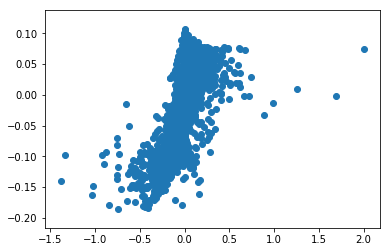

In [1212]:
plt.scatter(y_test,predictions)